(content:modules:gpr:1dexample)=
# 1D Example

```{todo}
Write this section.
```


## Load modules and start Fesslix engine

In [1]:
import fesslix as flx
flx.load_engine()
import fesslix.gpr
import fesslix.tools

import matplotlib.pyplot as plt
import numpy as np

Random Number Generator: MT19937 - initialized with rand()=280012050;
Random Number Generator: MT19937 - initialized with 1000 initial calls.


## Create random samples

In [2]:
N_smpls_max = 1000
eps_sd      = 0.2  # »» 1.1 gives problems
## ------------------------------------------
## Uncertainties of model input
## ------------------------------------------
config_rv_X     = { 'name':'X',   'type':'uniform', 'a':0., 'b':10. }
config_rv_noise = { 'name':'eps', 'type':'normal', 'mu':0., 'sd':eps_sd }
rv_set = flx.rv_set( {'name':'rv_set'}, [ config_rv_X, config_rv_noise ] )

## ------------------------------------------
## Model output
## ------------------------------------------
model = [ "sin(rbrv(rv_set::X))+1+rbrv(rv_set::eps)" ]

## ------------------------------------------
## Reference truth
## ------------------------------------------
plot_lim = [-5.,20]
X_vals = fesslix.tools.discretize_x(plot_lim[0], plot_lim[1], x_disc_N=200)
Y_truth = np.sin(X_vals)+1.

## ------------------------------------------
## Data box for storing samples
## ------------------------------------------
dbox = flx.dataBox(2,1)
dbox.write2mem( {
    'N_reserve': N_smpls_max,
    'cols': [0,1]
    } )

## ------------------------------------------
## Generate random realizations of the model
## ------------------------------------------
sampler = flx.sampler(['rv_set'])
sampler.perform_MCS(N_smpls_max, model, dbox)
smpls_X = dbox.extract_col_from_mem(1)
smpls_Y = dbox.extract_col_from_mem(0)
print(np.std(smpls_X), np.std(smpls_Y))

2.869937 0.7107549


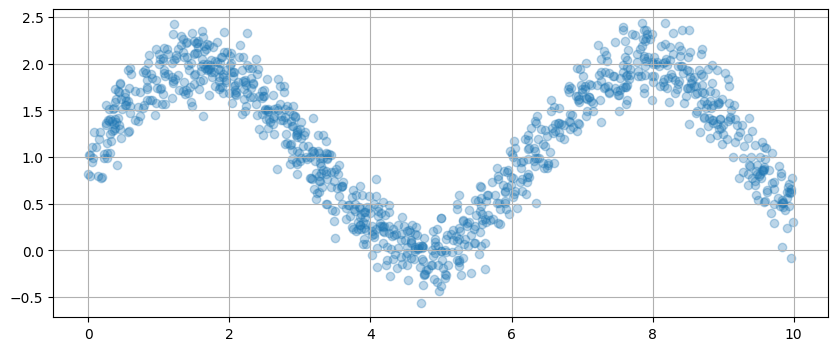

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(smpls_X,smpls_Y,alpha=0.3)
plt.grid()
plt.show()

## Define Gaussian process

In [4]:
config_gp = { 'name':'gp_1', 
              'Ndim':1, 
              #'mean_type':'zero', 
              'mean_type':'universal', 
              'mean_polyo':0, 
              'kernel_lst':['gauss'], 
              'useLSE':True
            }
gp_1 = fesslix.gpr.gp(config_gp)
config_gp['name'] = 'gp_2'
config_gp['useLSE'] = False
gp_2 = fesslix.gpr.gp(config_gp)

In [5]:
def gp_summarize(gp):
    gp_info = gp.info()
    prior_intercept = None
    if 'para_vec' in gp_info['mean']:
        prior_intercept = gp_info['mean']['para_vec'][0]*gp_info['mean']['normalizef']
    sd_noise = gp_info['noise']
    sd_kernel = gp_info['kernel']['kernel_sd']
    corr_l = gp_info['kernel']['para_vec'][1]*gp_info['kernel']['n_vec'][1]
    logl = gp_info['logl_obsv']
    print(f"{gp_info['name']}: {logl:10.2e} {sd_noise:8.4f} {sd_kernel:6.2f} {prior_intercept:6.2f} {corr_l:6.2f}")

## Condition the Gaussian process on data

In [6]:
N = 100
gp_1.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False)
gp_2.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False)
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:       -inf   0.0000   0.71   1.00   2.82
gp_2:       -inf   0.0000   0.71   1.15   2.82


In [7]:
if True:
    gp_1.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=True)
    gp_2.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=True)
else:
    noise_val = 0.0
    for i in range(20):
        noise_val += 0.01
        gp_1.noise_white(noise_val)
        gp_2.noise_white(noise_val)
        print( f"{noise_val:4.2f} » {gp_1.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False):10.2f} » {gp_2.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False):10.2f}" )
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:   4.87e+00   0.1918   1.16   0.79   2.82
gp_2:   2.13e+00   0.1926   0.71   1.15   2.82


In [8]:
if False:
    gp_1_info = gp_1.info()
    print( "noise log:", gp_1_info['noise_log'] )

In [9]:
def plot_GP(gp, color):
    Y_vals = np.empty(len(X_vals))     
    sigma_vals = np.empty(len(X_vals))  
    for i in range(len(X_vals)):
        Y_vals[i], sigma_vals[i] = gp.predict([X_vals[i]],type="mean_sd",predict_noise=False)
    plt.plot(X_vals,Y_vals, color=color)
    plt.plot(X_vals,Y_vals+2*sigma_vals, color=color, ls=':')
    plt.plot(X_vals,Y_vals-2*sigma_vals, color=color, ls=':')
    for i in range(len(X_vals)):
        Y_vals[i], sigma_vals[i] = gp.predict([X_vals[i]],type="mean_sd",predict_noise=True)
    plt.plot(X_vals,Y_vals+2*sigma_vals, color=color, ls='--')
    plt.plot(X_vals,Y_vals-2*sigma_vals, color=color, ls='--')

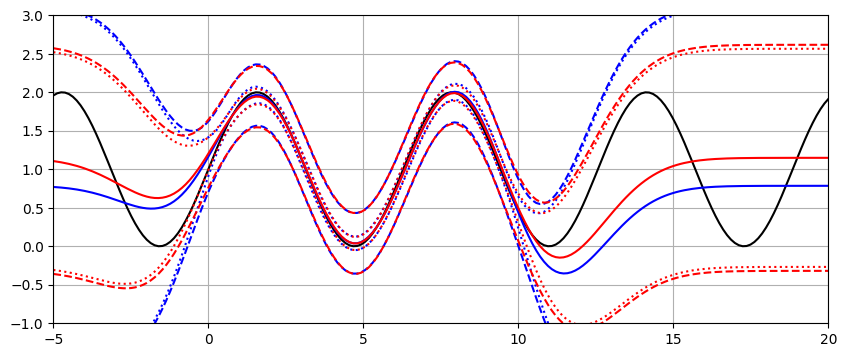

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(X_vals,Y_truth,color='black')
plot_GP(gp_1, color='blue')
plot_GP(gp_2, color='red')
ax.set_ylim([-1., 3.])
ax.set_xlim(plot_lim)
plt.grid()
plt.show()

## optimize process parameters

In [11]:
gp_1.optimize()
gp_1_info = gp_1.info()
print( gp_1_info['opt_log'] )

    flxGPProj::likeli_f_89 4.86756   ( 0 )   no
       initial point estimate: 4.867565 at ( 0 ) dim=1
    flxGPProj::likeli_f_89 4.86756   ( 0 )   no
    flxGPProj::likeli_f_89 -85.4991   ( 1 )   yes
    flxGPProj::likeli_f_89 -5.7698   ( -1 )   yes
    flxGPProj::likeli_f_89 0.743843   ( -0.5 )   yes
    flxGPProj::likeli_f_89 -15.2342   ( 0.5 )   yes
    flxGPProj::likeli_f_89 3.7719   ( -0.25 )   yes
    flxGPProj::likeli_f_89 2.04791   ( 0.25 )   yes
    flxGPProj::likeli_f_89 4.6631   ( -0.125 )   yes
    flxGPProj::likeli_f_89 4.20605   ( 0.125 )   yes
    flxGPProj::likeli_f_89 4.8656   ( -0.0625 )   yes
    flxGPProj::likeli_f_89 4.65827   ( 0.0625 )   yes
    flxGPProj::likeli_f_89 4.89237   ( -0.03125 )   yes
    flxGPProj::likeli_f_89 4.8656   ( -0.0625 )   yes
    flxGPProj::likeli_f_89 4.88646   ( -0.015625 )   yes
    flxGPProj::likeli_f_89 4.88538   ( -0.046875 )   yes
    flxGPProj::likeli_f_89 4.89103   ( -0.0234375 )   yes
    flxGPProj::likeli_f_89 4.89048   ( -0.03

In [12]:
for i in range(10):
    gp_1.optimize()
    gp_summarize(gp_1)  

gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73


In [13]:
gp_2.optimize()
#gp_2_info = gp_2.info()
#print( gp_2_info['opt_log'] )

4.9466513463173385

In [14]:
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57


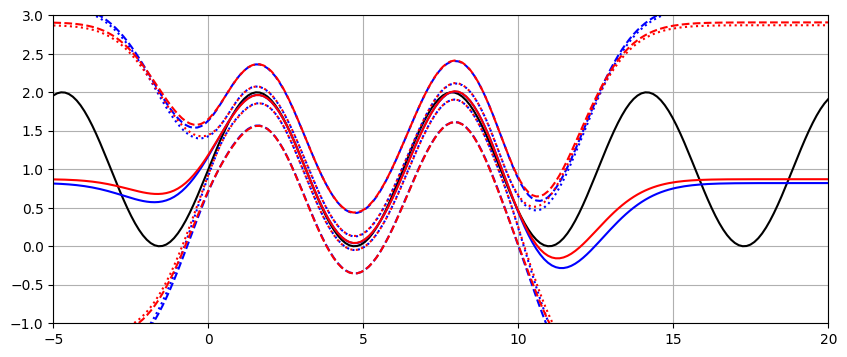

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(X_vals,Y_truth,color='black')
plot_GP(gp_1, color='blue')
plot_GP(gp_2, color='red')
ax.set_ylim([-1., 3.])
ax.set_xlim(plot_lim)
plt.grid()
plt.show()

## optimize noise based on optimized parameters

In [16]:
def fun_opt_noise(gp):
    for i in range(10):
        gp_summarize(gp)    
        print( i, gp.optimize() )
        gp_summarize(gp)    
        gp_1.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N], init_pvec=False)
        gp_summarize(gp)    

In [17]:
fun_opt_noise(gp_1)

gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
0 4.892369047253894
gp_1:   4.89e+00   0.1910   1.15   0.82   2.73
gp_1:   4.91e+00   0.1918   1.10   0.82   2.73
gp_1:   4.91e+00   0.1918   1.10   0.82   2.73
1 4.92332817020079
gp_1:   4.92e+00   0.1918   1.10   0.84   2.68
gp_1:   4.93e+00   0.1918   1.06   0.84   2.68
gp_1:   4.93e+00   0.1918   1.06   0.84   2.68
2 4.936512675133706
gp_1:   4.94e+00   0.1915   1.06   0.85   2.65
gp_1:   4.94e+00   0.1918   1.04   0.85   2.65
gp_1:   4.94e+00   0.1918   1.04   0.85   2.65
3 4.942606583478508
gp_1:   4.94e+00   0.1918   1.04   0.86   2.61
gp_1:   4.95e+00   0.1918   1.02   0.86   2.61
gp_1:   4.95e+00   0.1918   1.02   0.86   2.61
4 4.9463150052278735
gp_1:   4.95e+00   0.1918   1.02   0.86   2.60
gp_1:   4.95e+00   0.1918   1.01   0.86   2.60
gp_1:   4.95e+00   0.1918   1.01   0.86   2.60
5 4.946720554588374
gp_1:   4.95e+00   0.1918   1.01   0.86   2.60
gp_1:   4.95e+00   0.1918   1.01   0.86   2.60
gp_1:   4.95e+00   0.1918   1.01  

In [18]:
fun_opt_noise(gp_2)

gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
0 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
1 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
2 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
3 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
4 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
5 4.9466513463173385
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57
gp_2:   4.95e+00   0.1926   

In [19]:
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:   4.95e+00   0.1918   1.01   0.86   2.60
gp_2:   4.95e+00   0.1926   1.00   0.87   2.57


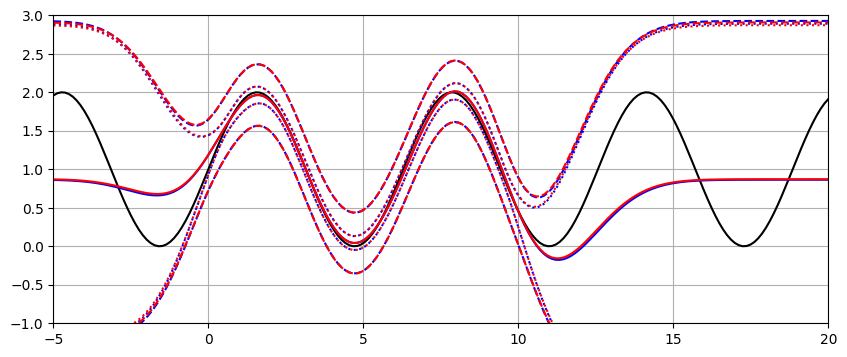

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(X_vals,Y_truth,color='black')
plot_GP(gp_1, color='blue')
plot_GP(gp_2, color='red')
ax.set_ylim([-1., 3.])
ax.set_xlim(plot_lim)
plt.grid()
plt.show()

## automatic optimization of noise

In [21]:
gp_1.noise_white(0.1)
gp_2.noise_white(0.1)
gp_1.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False)
gp_2.condition_on(smpls_X[:N].reshape(-1, 1),smpls_Y[:N],opt_noise=False)
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:   4.70e+00   0.1898   1.34   0.80   2.82
gp_2:  -6.17e+01   0.1000   0.71   1.15   2.82


In [22]:
gp_1.optimize(opt_noise=True)

4.94856091739392

In [23]:
gp_2.optimize(opt_noise=True)

4.948213566613028

In [24]:
gp_summarize(gp_1)        
gp_summarize(gp_2)

gp_1:   4.95e+00   0.1918   0.99   0.88   2.56
gp_2:   4.95e+00   0.1917   0.98   0.88   2.56


In [25]:
print( gp_1.info()['opt_log'] )

    flxGPProj::likeli_f_89 4.7014   ( 0, -1.66188 )   no
       initial point estimate: 4.7014 at ( 0, -1.66188 ) dim=2
    flxGPProj::likeli_f_89 4.7014   ( 0, -1.66188 )   no
    flxGPProj::likeli_f_89 -82.062   ( 1, -1.66188 )   yes
    flxGPProj::likeli_f_89 -6.47677   ( 0, -3.32376 )   yes
    flxGPProj::likeli_f_89 -32.5398   ( -1, -3.32376 )   yes
    flxGPProj::likeli_f_89 -14.2899   ( -0.5, -2.90829 )   yes
    flxGPProj::likeli_f_89 -2.26352   ( 0.5, -2.07735 )   yes
    flxGPProj::likeli_f_89 -59.967   ( 0.5, -0.41547 )   yes
    flxGPProj::likeli_f_89 1.23183   ( 0.125, -2.59669 )   yes
    flxGPProj::likeli_f_89 -3.19098   ( -0.375, -2.18122 )   yes
    flxGPProj::likeli_f_89 3.93702   ( 0.28125, -2.10332 )   yes
    flxGPProj::likeli_f_89 1.1033   ( 0.15625, -1.16851 )   yes
    flxGPProj::likeli_f_89 3.26844   ( 0.132812, -2.23965 )   yes
    flxGPProj::likeli_f_89 4.05788   ( 0.148438, -1.52556 )   yes
    flxGPProj::likeli_f_89 4.59563   ( -0.132812, -1.08412 )   yes
 

In [26]:
print( gp_2.info()['opt_log'] )

    flxGPProj::likeli_f_89 -61.6822   ( 1, 0, 0, -2.30259 )   no
       initial point estimate: -61.6822 at ( 1, 0, 0, -2.30259 ) dim=4
    flxGPProj::likeli_f_89 -61.6822   ( 1, 0, 0, -2.30259 )   no
    flxGPProj::likeli_f_89 -67.9729   ( 2, 0, 0, -2.30259 )   yes
    flxGPProj::likeli_f_89 -60.0125   ( 1, 1, 0, -2.30259 )   yes
    flxGPProj::likeli_f_89 -456.187   ( 1, 1, 1, -2.30259 )   yes
    flxGPProj::likeli_f_89 -16379.3   ( 1, 1, 0, -4.60517 )   yes
    flxGPProj::likeli_f_89 -111.968   ( 1.5, 0, 0.5, 0 )   yes
    flxGPProj::likeli_f_89 -25.597   ( 1.75, -0.5, -0.75, -1.15129 )   yes
    flxGPProj::likeli_f_89 -189.44   ( 2.125, -1.25, -1.625, -0.575646 )   yes
    flxGPProj::likeli_f_89 -4305.21   ( 1.375, 0.25, -0.875, -4.02952 )   yes
    flxGPProj::likeli_f_89 -28.4968   ( 1.46875, 0.0625, 0.15625, -1.00738 )   yes
    flxGPProj::likeli_f_89 -17.0258   ( 0.609375, 0.28125, -0.296875, -1.07934 )   yes
    flxGPProj::likeli_f_89 -66.2706   ( -0.0859375, 0.421875, -0.44531